## **Zero-shot image classficiation with GPT-4o**

We perform zero-shot classification of astronomical images using the proprietary GPT-4o Large Multimodal Model, accessed through openAI's API

[Introducting GPT-4o](https://openai.com/index/hello-gpt-4o/)

We use two different datasets:

- LSBGs vs Artifacts, from [Tanoglidis et. al. 2021](https://arxiv.org/abs/2011.12437)
- [GalaxyMNIS](https://github.com/mwalmsley/galaxy_mnist), which has 4 different morphological categories (smooth and round, smooth and cigar-shaped, edge-on disk, and unbarred spiral).

From each dataset, we select 500 images to classify.

#### **Import basic packages**

In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import random
import json
from time import sleep

from IPython.display import Image

# ================================================
# Matplotlib, seaborn and plot pretty
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):


    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

In [2]:
import base64
import requests

In [3]:
# scikit-learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

**Define function to make nice plots of the confusion matrix**


In [4]:
# Function that makes nice plots of the confusion matrix
def plot_confusion_matrix(y_true, y_pred, rot, l_size, ax_size, size, svname, class_names):
  """
  Inputs: y_true: array of true values
          y_pred: array of predicted values
          rot: label rotation
          l_size: label size
          ax_size: axis title size
          size: size of the confusion matrix
          svname: name, in order to save as a pdf
          class_names: the names to be used as class names in the confusion matrix

  Output: Plot of the confusion matrix
  """

  # Get the confusion matrix
  con_mat = confusion_matrix(y_true, y_pred)
  # Dimension / number of classes
  dim = len(class_names)


  # Get annotations and normalized confusion matrix

  # Normalized confusion matrix
  con_mat_normalized = np.zeros([dim,dim])
  annots = np.zeros([dim,dim],dtype='U6')

  # Populate normalized confusion matrix and annotations
  for i in range(dim):
    con_mat_normalized[i] = con_mat[i]/np.sum(con_mat[i])
    for j in range(dim):
      annots[i,j] = "("+"{:.2f}".format(con_mat_normalized[i,j])+")"



  # Plot the matrix now
  plt.figure(figsize = (size,size))

  sns.heatmap(con_mat_normalized.T, square=True, annot=annots.T, annot_kws={'va':'top',"size": 19},cmap='Blues',fmt='', cbar=False,
            cbar_kws={'shrink':0.94})
  g= sns.heatmap(con_mat.T, square = True, annot=True,annot_kws={'va':'bottom',"size": 21},fmt='.0f', cmap='Blues', cbar=False,
            xticklabels= class_names,
            yticklabels= class_names)

  g.set_xticklabels(class_names, fontsize = 15)
  g.set_yticklabels(class_names, fontsize = 15)

  # Ticks for colorbar
  cax = plt.gcf().axes[-1]
  if (rot!=None):
    cax.tick_params(labelsize=l_size,labelrotation=rot)
  else:
    cax.tick_params(labelsize=l_size)
  # =========================================
  # =========================================
  plt.xlabel('True label',fontsize=ax_size)
  plt.ylabel('Predicted label',fontsize=ax_size)

  plt.tight_layout()

  # Save in .png and .pdf formats
  plt.savefig("Images/results/"+svname+".png")
  plt.savefig("Images/results/"+svname+".pdf")
  plt.show()

### Connect to Google Drive

In [5]:
# Mount drive to upload/download  datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Dowload Datasets**

- **LSBGs vs Artifacts**

In [6]:
# Remove
#!rm -rf UPenn_DS_Hangout
!git clone https://github.com/dtanoglidis/UPenn_DS_Hangout

fatal: destination path 'UPenn_DS_Hangout' already exists and is not an empty directory.


In [7]:
# Change to that directory where the data lie
%cd UPenn_DS_Hangout

/content/UPenn_DS_Hangout


In [8]:
#Concatenate the data

# Data
X_1 = np.load("X_data_1.npy");X_2 = np.load("X_data_2.npy");X_3 = np.load("X_data_3.npy")
X_4 = np.load("X_data_4.npy");X_5 = np.load("X_data_5.npy")

X_data = np.concatenate((X_1,X_2,X_3,X_4,X_5))

# Labels
y_lab = np.load("y_labels.npy")

In [9]:
# Change to the LMM directory

%cd ../drive/MyDrive/Multimodal/

/content/drive/MyDrive/Multimodal


- **galaxyMNIST**

Uncomment the first time, to download the galaxyMNIST dataset.

Then you can load the low ($64\times64$ pixel) or high ($256\times256$ pixel) resolution images. Here we opt to us the low resolution images, for lower payload when invoking the GPT-4o pipeline.

**Note**: you may have to restart the kernel after installing the package

In [15]:
#!git clone https://github.com/mwalmsley/galaxy_mnist
!pip install -e galaxy_mnist

Obtaining file:///content/drive/MyDrive/Multimodal/galaxy_mnist
  Preparing metadata (setup.py) ... done
  Running setup.py develop for galaxyMNIST


In [10]:
from galaxy_mnist import GalaxyMNIST

# Load the 64x64 pixel images
dataset = GalaxyMNIST(
    root='galaxy_mnist',
    download=True,
    train=True  # by default, or set False for test set
)

In [11]:
# images and labels here
images, labels = dataset.data, dataset.targets

# convert to numpy
images_np = images.numpy()
labels_np = labels.numpy()

# rearrange the images in a channel-last format
images_ra = np.moveaxis(images_np, source=1, destination=3)

## Function for zero-shot classification through API calls

Function that call the openAI API; it get as inputs the prompts and images.

We also need to define a function that transforms the images in an appropriate base64 format

In [ ]:
# Your openAI API key here
api_key =

In [ ]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [ ]:
# Zero-shot function
def gpt_4o_zero_shot(inp_prompt,enc_image):

  """
  Function that returns zero shot prediction from GPT-4o

  Inputs: inp_prompt (input prompt)
          enc_image (base 64 encoded image)
  Output: output prediction of the GPT-4o model
  """

  # Define payload
  payload = {
    "model": "gpt-4o",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": inp_prompt
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{enc_image}"
            }
          },
          {
            "type": "text",
            "text": "Look well the image above. To which category does it belong? Respond only with a number"
          }
        ]
      }
    ],
    "max_tokens": 500,
    "temperature": 0.0,
    "n": 1
  }

  # Get response
  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

  # Return final result
  return response.json()['choices'][0]['message']['content']

## **I) LSBG vs Artifacts**


- **Make a plot of examples**

In [ ]:
X_pos = X_data[y_lab==1.][0:50] #Positives - LSBGs
X_neg = X_data[y_lab==0.][0:50] #Negatives - Artifacts

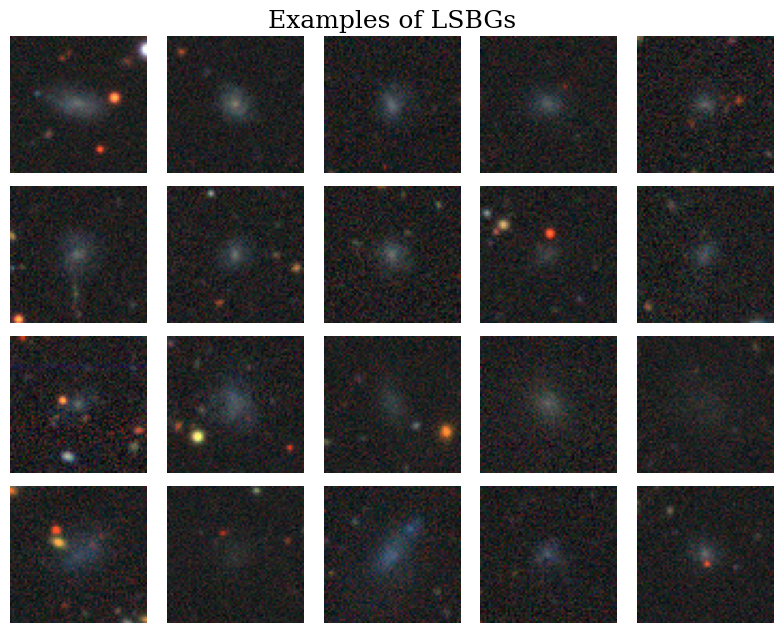

In [ ]:
# Plot Examples of LSBGs
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_pos[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)

plt.tight_layout()
# Save in .png and .pdf formats
plt.savefig("Images/results/LSBG_examples.png")
plt.savefig("Images/results/LSBG_examples.pdf")
plt.show()

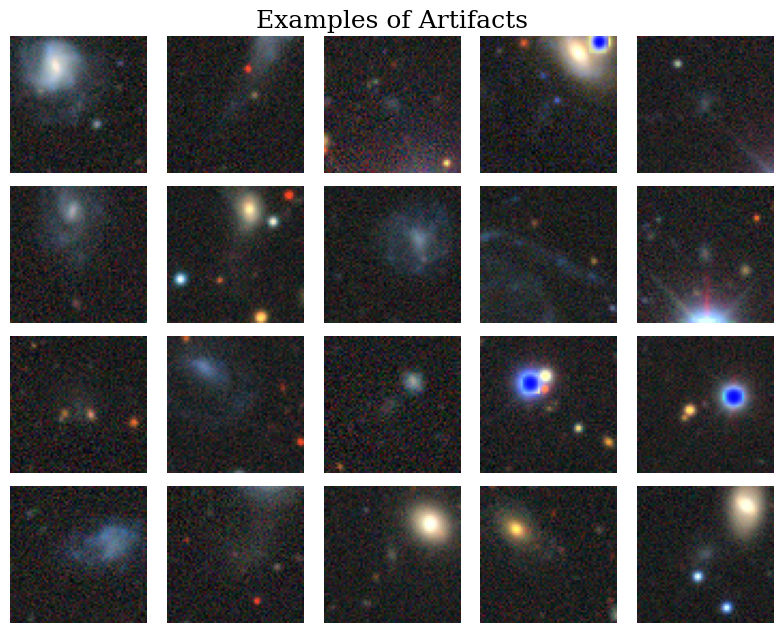

In [ ]:
# Plot examples of artifacts
plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_neg[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)

plt.tight_layout()
# Save in .png and .pdf formats
plt.savefig("Images/results/Artifact_examples.png")
plt.savefig("Images/results/Artifact_examples.pdf")
plt.show()

**Define classification prompt**

In [ ]:
prompt_LSBG = """
You are tasked to classify astronomical images. Each image belongs to one of two categories:

Low Surface Brightness Galaxies (LSBG, Category 1) or non-LSBG (Category 0).
Note that category 0 may also include parts or off-centered LSBGs.

Here are some characteristics of the two categories:

Category 1, LSBG: The image is dominated by a well-centered,
circular or elliptical, diffuse galaxy-like light source. There may be some
smaller, more compact light sources nearby.

Category 0: In this category belong all the images that do not fit into the
category 1 definiton. Examples may include: off-centered bright galaxies, diffuse light,
bright stars, light reflections.

To what category does the image belong?
"""

### Run in a loop

In [ ]:
n = 500

# initialize an array of predictions
y_pred_LSBG = np.zeros(n)

# Run
for i in range(n):
  # Save image in directory; PNG format
  plt.imsave('Images/Example_Image.png', X_data[i])
  # encode it
  encoded = encode_image('Images/Example_Image.png')

  # Get response
  resp = gpt_4o_zero_shot(prompt_LSBG,encoded)

  y_pred_LSBG[i] = int(resp)

  if (i%10==0):
    sleep(3)
    if (i%50==0):
      print(i)

0
50
100
150
200
250
300
350
400
450


In [ ]:
# Save the predictions array, so we don't have to run the predictions every time
np.save('preds_LSBGs',y_pred_LSBG)

# We can load the array if we want to here
# y_pred_LSBG = np.load('preds_LSBGs.npy')

- Make a plot of the confusion matrix now:

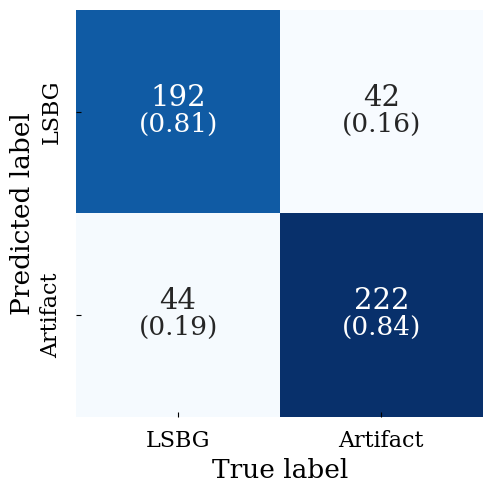

In [ ]:
class_names = ['LSBG','Artifact']
plot_confusion_matrix(y_lab[:n], y_pred_LSBG, rot=None, l_size=16, ax_size = 19, size=5.0, svname='LSBG_vs_Artifact', class_names=class_names)

- Print metrics now:

In [ ]:
print("Overall accuracy:",accuracy_score(y_lab[:n], y_pred_LSBG))
print("Precision:", precision_score(y_lab[:n],y_pred_LSBG))
print("Recall:", recall_score(y_lab[:n],y_pred_LSBG))

Overall accuracy: 0.828
Precision: 0.8345864661654135
Recall: 0.8409090909090909


## **II) Galaxy Morphology**

- **Make plots of examples**

Let's first get some examples of each of the four categories

In [12]:
images_smooth_round = images_ra[labels_np==0][0:50]
images_smooth_cigar = images_ra[labels_np==1][0:50]
images_edge_on = images_ra[labels_np==2][0:50]
images_edge_spiral = images_ra[labels_np==3][0:50]

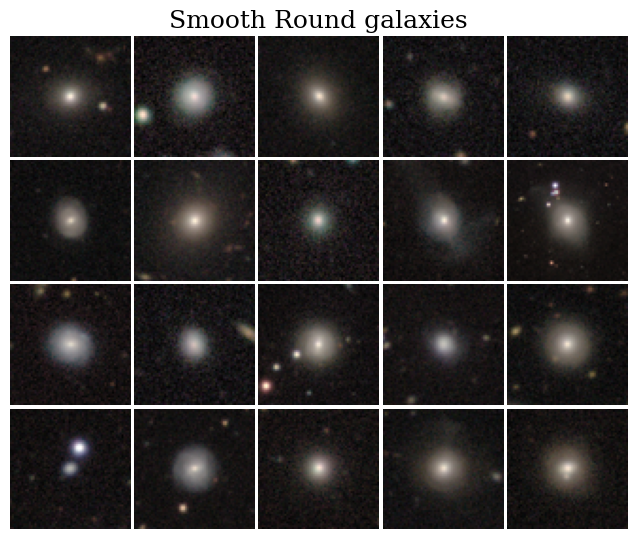

In [17]:
# Plot Examples of smooth_round
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Smooth Round galaxies",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_smooth_round[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)


# Save in .png and .pdf formats
plt.savefig("Images/results/Smooth_Round_examples.png")
plt.savefig("Images/results/Smooth_Round_examples.pdf")

plt.show()

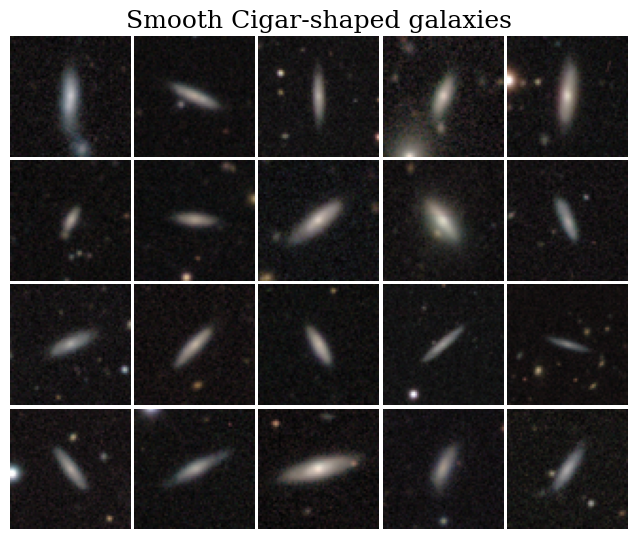

In [18]:
# Plot examples of smooth Cigar-shaped galaxies
plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))


for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Smooth Cigar-shaped galaxies",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_smooth_cigar[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Save in .png and .pdf formats
plt.savefig("Images/results/Smooth_Cigar_examples.png")
plt.savefig("Images/results/Smooth_Cigar_examples.pdf")

plt.show()

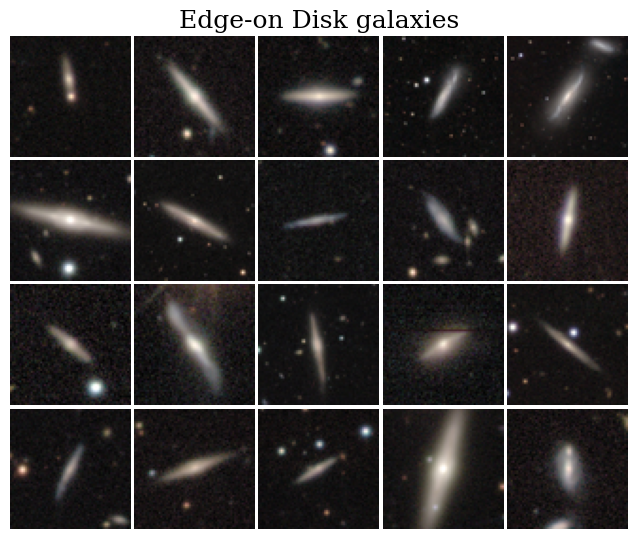

In [19]:
# Plot examples of Edge-on galaxies
plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))


for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Edge-on Disk galaxies",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_edge_on[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Save in .png and .pdf formats
plt.savefig("Images/results/Edge_on_examples.png")
plt.savefig("Images/results/Edge_on_examples.pdf")

plt.show()

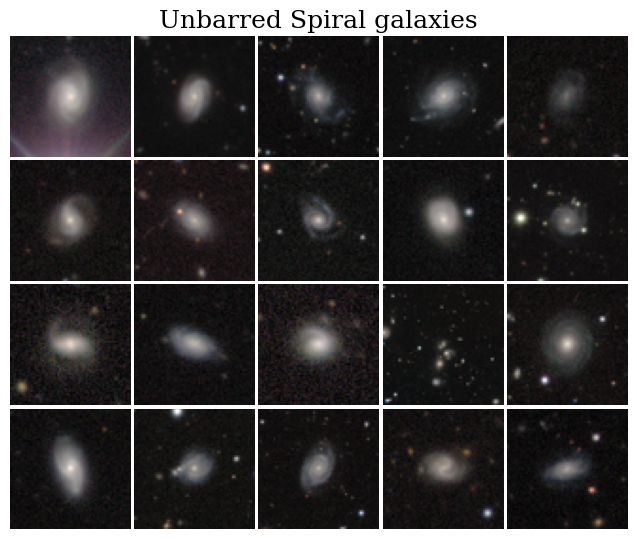

In [20]:
# Plot examples of Unbarred spiral galaxies
plt.figure(figsize=(4*n_cols*0.4, 4*n_rows*0.4))


for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Unbarred Spiral galaxies",fontsize=18)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(images_edge_spiral[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Save in .png and .pdf formats
plt.savefig("Images/results/Unbarred_Spiral_examples.png")
plt.savefig("Images/results/Unbarred_Spiral_examples.pdf")

plt.show()

**Define Classification prompt**

Now we are ready to classify, so we define the classification prompt

In [ ]:
prompt_morphology = """
You are tasked to classify images depicting galaxies, into four morphological categories:

Category 0: smooth and round galaxy. Should not have signs of spires.

Category 1: smooth and cigar-shaped galaxy, looks like being seen edge on. This should not have signs of spires of a spiral galaxy

Category 2: edge-on-disk/spiral galaxy. This disk galaxy should have signs of spires, as seen from an edge-on perspective

Category 3:  unbarred spiral galaxy. Has signs of a disk and/or spires

Note that categories 1 and 2 tend to be very similar to each other.
To categorize them, ask yourself the following question: Is this galaxy very smooth, maybe with a small bulge? Then it
belongs to category 1. Does it have irregularities/signs of structure? Then it belongs to category 2.

To which category does the image belong?
"""

### Run classification in a loop

In [ ]:
n = 500

y_pred_morphology = np.zeros(n)

for i in range(n):
  # Save image in directory; PNG format
  plt.imsave('Example_Image.png', images_ra[i])
  # encode it
  encoded = encode_image('Example_Image.png')


  # Get response
  resp = gpt_4o_zero_shot(prompt_morphology,encoded)

  y_pred_morphology[i] = int(resp)

  if (i%10==0):
    sleep(5)
    if (i%50==0):
      print(i)


0
50
100
150
200
250
300
350
400
450


In [ ]:
# Save the predictions array, so we don't have to run the predictions every time
np.save('preds_morphology',y_pred_morphology)

# We can load the array if we want to here
#y_pred_morphology = np.load('preds_morphology.npy')

- Make plot of the **confusion matrix**

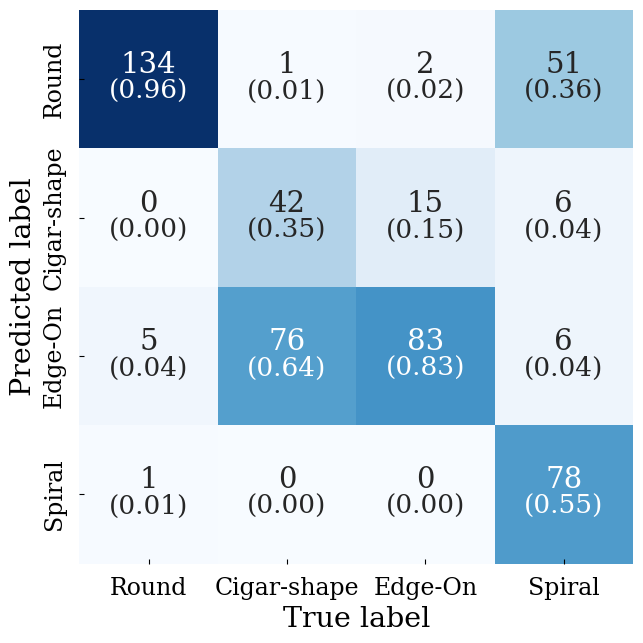

In [ ]:
class_names = ['Round', 'Cigar-shape', 'Edge-On','Spiral']

plot_confusion_matrix(labels_np[:n], y_pred_morphology, rot=None,l_size=17, ax_size=20.5, size=6.5,svname='morphology', class_names=class_names)

Print metrics now

In [ ]:
print("Overall accuracy:",accuracy_score(labels_np[:n], y_pred_morphology))
#print("Precision:", precision_score(y_lab[:n],y_pred_morphology))
#print("Recall:", recall_score(y_lab[:n],y_pred_morphology))

Overall accuracy: 0.674


Combine them in three categories now

In [ ]:
# Predictions
y_pred_3 = np.copy(y_pred_morphology)
y_pred_3[(y_pred_3==1)|(y_pred_3==2)] = 1
y_pred_3[y_pred_3>2] = 2

# True values
y_true_3 = np.copy(labels_np[:n])
y_true_3[(y_true_3==1)|(y_true_3==2)] = 1
y_true_3[y_true_3>2] = 2

Make new confusion matrix now

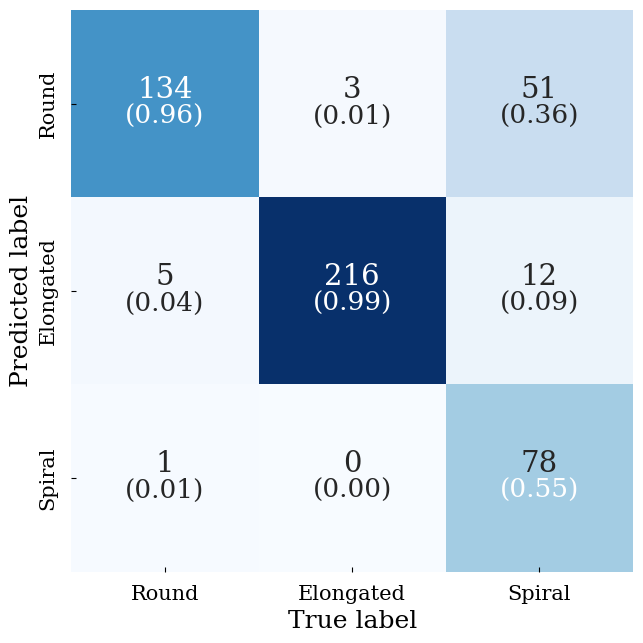

In [ ]:
class_names = ['Round', 'Elongated','Spiral']

plot_confusion_matrix(y_true_3, y_pred_3, rot=None, size=6.5,svname='morphology', class_names=class_names)